=== Status Fitur (sebelum modeling) ===


,Fitur,NonNull_Count,All_NaN,Action
0,Curah_Hujan,0,True,DROP
2,Angin,264924,False,USE
3,Awan,264924,False,USE
1,Kelembaban,264924,False,USE
4,Tanggal_numeric,264924,False,USE



=== Evaluasi Model Regresi (Suhu) ===


,Metrik,Nilai
0,MAE,1.0721
1,MSE,1.9030
2,R²,0.5059



=== Actual vs Predicted (sample) ===


,Tanggal,Kelembaban,Angin,Tanggal_numeric,Suhu_Aktual,Suhu_Prediksi
0,1970-01-01 00:00:00.631152000,86,1.36,0.631152,25.82,26.266639
1,1970-01-01 00:00:00.631155600,84,2.09,0.631156,26.20,26.548567
2,1970-01-01 00:00:00.631159200,84,2.44,0.631159,26.45,26.521924
3,1970-01-01 00:00:00.631162800,82,2.29,0.631163,26.80,26.854211
4,1970-01-01 00:00:00.631166400,82,1.71,0.631166,27.04,26.913270
5,1970-01-01 00:00:00.631170000,82,1.67,0.631170,27.23,26.928507
6,1970-01-01 00:00:00.631173600,82,2.17,0.631174,27.32,26.891915
7,1970-01-01 00:00:00.631177200,82,2.91,0.631177,27.29,26.839405
8,1970-01-01 00:00:00.631180800,81,2.40,0.631181,27.34,27.028682
9,1970-01-01 00:00:00.631184400,82,1.91,0.631184,27.23,26.887432


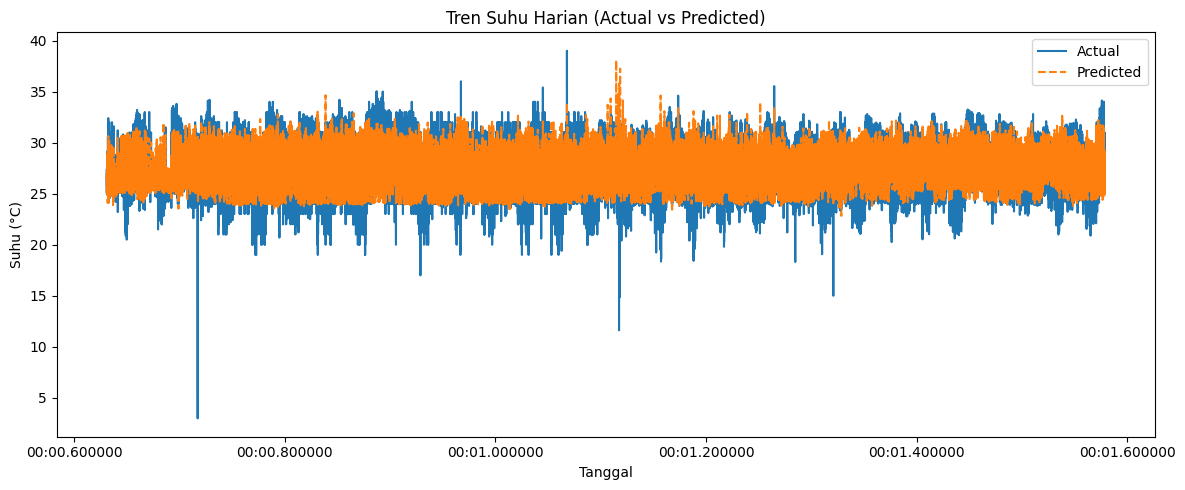

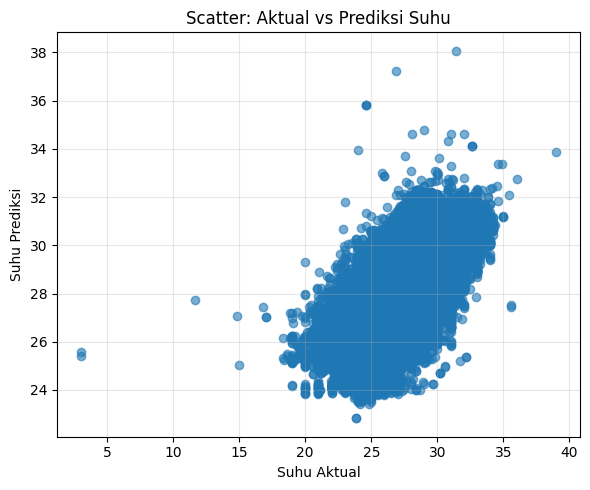


=== Insight & Catatan ===


,Insight / Catatan
0,Fitur ['Curah_Hujan'] berisi 100% NaN dan di-D...
1,Evaluasi di atas adalah in-sample (tanpa train...
2,Alternatif: tetap pertahankan fitur all-NaN de...


In [1]:
# ---------- Import library ----------
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ---------- Konfigurasi ----------
N_ROWS = None                   # None = load semua data
DATA_PATH = "../data/cuaca_clean.csv"
RANDOM_STATE = 42               # reproducibility

# ---------- Load dataset ----------
df = pd.read_csv(DATA_PATH, nrows=N_ROWS)
df['Tanggal'] = pd.to_datetime(df['Tanggal'], errors='coerce')  # pastikan tipe datetime

# ---------- Pastikan kolom numeric ----------
for col in ['Suhu','Kelembaban','Curah_Hujan','Angin']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# ---------- Optional: one-hot encoding Awan ----------
if df['Awan'].dtype == 'object':
    df = pd.get_dummies(df, columns=['Awan'], drop_first=True)

# ---------- Representasi waktu ----------
# ubah Tanggal menjadi angka (timestamp) untuk modeling
df['Tanggal_numeric'] = df['Tanggal'].map(lambda x: x.timestamp() if pd.notnull(x) else np.nan)

# ---------- Fitur & Target ----------
X_cols = [c for c in df.columns if c not in ['Suhu','Tanggal']]
X = df[X_cols].copy()
y = df['Suhu'].copy()

# ---------- Deteksi fitur all-NaN ----------
non_null_counts = X.notna().sum()
all_nan_cols = non_null_counts[non_null_counts == 0].index.tolist()  # fitur 100% NaN
used_cols = [c for c in X_cols if c not in all_nan_cols]

# Buat tabel status fitur untuk review
feature_status = pd.DataFrame({
    "Fitur": X_cols,
    "NonNull_Count": [int(non_null_counts[c]) for c in X_cols],
    "All_NaN": [c in all_nan_cols for c in X_cols],
    "Action": ["DROP" if c in all_nan_cols else "USE" for c in X_cols]
}).sort_values(["All_NaN","Fitur"], ascending=[False, True])

print("=== Status Fitur (sebelum modeling) ===")
display(feature_status)

# Drop fitur all-NaN agar model tidak bingung / muncul warning
if len(all_nan_cols) > 0:
    X = X[used_cols]

# ---------- Pipeline & Training ----------
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # isi NaN dengan mean
    ('regressor', LinearRegression())
])

pipeline.fit(X, y)
y_pred = pipeline.predict(X)

# ---------- Evaluasi model ----------
mae = mean_absolute_error(y, y_pred)
mse = mean_squared_error(y, y_pred)
r2  = r2_score(y, y_pred)

eval_tbl = pd.DataFrame({
    "Metrik": ["MAE", "MSE", "R²"],
    "Nilai": [mae, mse, r2]
})
print("\n=== Evaluasi Model Regresi (Suhu) ===")
display(eval_tbl.round(4))

# ---------- Tabel perbandingan sample ----------
preview_cols = [c for c in ['Kelembaban','Curah_Hujan','Angin','Tanggal_numeric'] if c in X.columns]
preview = df[['Tanggal'] + preview_cols].copy()
preview['Suhu_Aktual'] = y
preview['Suhu_Prediksi'] = y_pred
print("\n=== Actual vs Predicted (sample) ===")
display(preview.head(10))

# ---------- Visualisasi tren Suhu ----------
plt.figure(figsize=(12,5))
plt.plot(df['Tanggal'], y, label='Actual')
plt.plot(df['Tanggal'], y_pred, label='Predicted', linestyle='--')
plt.xlabel('Tanggal')
plt.ylabel('Suhu (°C)')
plt.title('Tren Suhu Harian (Actual vs Predicted)')
plt.legend()
plt.tight_layout()
plt.show()

# ---------- Visualisasi scatter Actual vs Predicted ----------
plt.figure(figsize=(6,5))
plt.scatter(y, y_pred, alpha=0.6)
plt.xlabel("Suhu Aktual")
plt.ylabel("Suhu Prediksi")
plt.title("Scatter: Aktual vs Prediksi Suhu")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ---------- Insight & Catatan ----------
notes = []

if len(all_nan_cols) > 0:
    notes.append(
        f"Fitur {all_nan_cols} berisi 100% NaN dan di-DROP. "
        "Model tidak menggunakan fitur ini. "
        "Jika 'Curah_Hujan' termasuk, ini penyebab warning sebelumnya."
    )

notes.append(
    "Evaluasi di atas adalah in-sample (tanpa train/test split) "
    "karena fokus notebook ini adalah tren. "
    "Untuk generalisasi gunakan split atau cross-validation."
)

notes.append(
    "Alternatif: tetap pertahankan fitur all-NaN dengan isi konstan (0) + indikator, "
    "tapi berisiko menambah noise. Default aman adalah DROP."
)

insight = pd.DataFrame({"Insight / Catatan": notes})
print("\n=== Insight & Catatan ===")
display(insight)
